In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 1
setup_one_gpu(GPU)

Picking GPU 1


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph

import tf_lab.point_clouds.in_out as pio

from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets

from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
                                                  
from general_tools.in_out.basics import create_dir, files_in_subdirs

from general_tools.simpletons import select_first_last_and_k

from geo_tool import Point_Cloud

from tf_lab.point_clouds.gan import model_saver_id

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.point_clouds.raw_gan import RawGAN

from tf_lab.point_clouds.generators_discriminators import mlp_discriminator, convolutional_discriminator,\
                                                          point_cloud_generator, leaky_relu, mlp_discriminator

from tf_lab.autopredictors.evaluate import read_saved_epochs

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
save_model = False
save_synthetic_samples = False
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/'

do_training = False
load_model = True
do_plotting = True
n_pc_samples = 2048

max_epochs = 1500
arch_tag = 'mlp_arch'
leak = 0.2
dropout_prob = 0.5

discriminator = mlp_discriminator
adaptive_training = None

beta = 0.5
disc_kwargs = {'non_linearity': leaky_relu(leak), 'dropout_prob': dropout_prob}
    
generator = point_cloud_generator
gen_kwargs = {'b_norm': False, 'layer_sizes':[64, 128, 256, 512, 1024], 'dropout_prob': dropout_prob}
experiment_name = class_name + '_'+ arch_tag + '_raw_gan_' + str(n_pc_samples) +  '_pts'

Give me the class type.
chair


In [5]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/gan/raw_gan')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))
full_pclouds_path = osp.join(full_pclouds_path, syn_id)
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_ids, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,
                                                                           n_threads=25, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [6]:
training_data = PointCloudDataSet(full_pclouds)

batch_size = 50
noise_params = {'mu':0, 'sigma': 0.5}
noise_dim = 512
init_lr = 0.0001

n_syn_samples = training_data.num_examples  # Same number as original GT data.

In [8]:
reset_tf_graph()

gan = RawGAN(experiment_name, init_lr, [n_pc_samples, 3], noise_dim,
             discriminator, generator, beta=beta, gen_kwargs=gen_kwargs, disc_kwargs=disc_kwargs)

accum_syn_data = []
train_stats = []

In [7]:
if do_training:
    for _ in range(max_epochs + 1):
        loss, duration = gan._single_epoch_train(training_data, batch_size, noise_params, adaptive=adaptive_training)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss, duration
        if save_model and epoch % 10 == 0:
            checkpoint_path = osp.join(train_dir, model_saver_id)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
            syn_d = gan.generate(n_syn_samples, noise_params)
            accum_syn_data.append(syn_d)
            for k in range(3):
                Point_Cloud(syn_d[k]).plot(in_u_sphere=True)
        train_stats.append((epoch,) + loss)

NameError: name 'ae_loss' is not defined

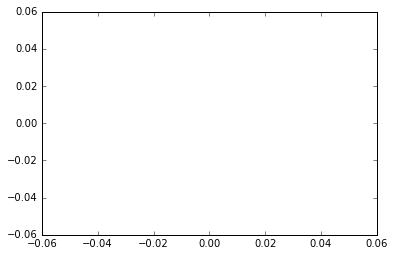

In [8]:
if do_plotting:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')

In [9]:
# saved_epochs = read_saved_epochs(train_dir)
# print saved_epochs
save_dir = osp.join(synthetic_data_out_dir, experiment_name)
create_dir(save_dir)
# for epoc in saved_epochs:
# for epoc in range(0,1600,100):    
for epoc in [500]:    
    print epoc
    if epoc == 0:
        continue
    gan.saver.restore(gan.sess, osp.join(train_dir,'models.ckpt' + '-' + str(epoc)))
    d = gan.generate(n_syn_samples, noise_params)
#     np.savez(osp.join(save_dir, 'epoch_' + str(epoc)), d)
    

500


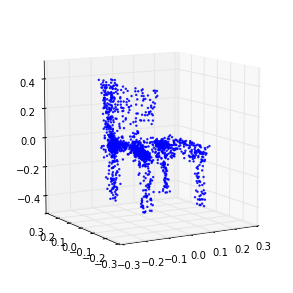

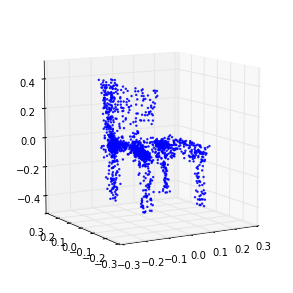

In [13]:
# Point_Cloud(d[30]).plot()

In [ ]:
epoch_to_check = 1500
n_check = 5
check_data = accum_syn_data[(epoch_to_check / 10)-1]
rids = np.random.choice(range(len(check_data)), size=n_check, replace=False)
for i in range(n_check):
    Point_Cloud(check_data[rids[i]]).plot(in_u_sphere=True)    

In [ ]:
synthetic_data_out_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/nips/our_synthetic_samples/'
saver_step = 10
if save_synthetic_samples:    
    create_dir(save_dir)
    for i, d in enumerate(accum_syn_data):
        epoc = str((i + 1) * saver_step)
        np.savez(osp.join(save_dir, 'epoch_' + epoc), d)